In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12



# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

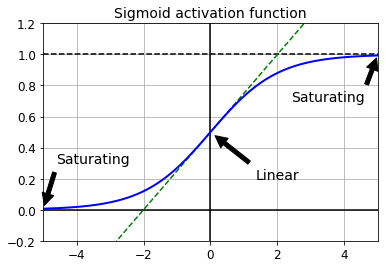

In [4]:

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2]);

In [5]:
import tensorflow as tf

In [14]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [15]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X,n_hidden1, activation = tf.nn.relu, 
                         kernel_initializer=he_init, name="hidden1")

# Leaky ReLU

In [16]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

[-5, 5, -0.5, 4.2]

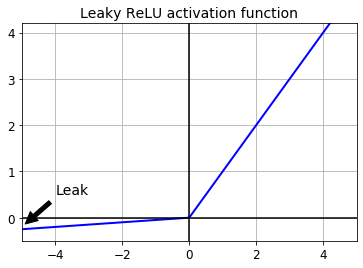

In [18]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])



In [19]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [20]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [22]:

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [23]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [24]:

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [25]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [27]:

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [28]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [31]:
def shuffle_batch(X,y,batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X)/batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [33]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        if epoch % 5 ==0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
        
        save_path = saver.save(sess, "./tf_logs/my_model_final.ckpt")
        

0 Batch accuracy: 0.86 Validation accuracy: 0.9048
5 Batch accuracy: 0.94 Validation accuracy: 0.9512
10 Batch accuracy: 0.92 Validation accuracy: 0.9658
15 Batch accuracy: 1.0 Validation accuracy: 0.9722
20 Batch accuracy: 1.0 Validation accuracy: 0.9752
25 Batch accuracy: 0.98 Validation accuracy: 0.9762
30 Batch accuracy: 1.0 Validation accuracy: 0.978
35 Batch accuracy: 1.0 Validation accuracy: 0.9788


## ELU

In [34]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

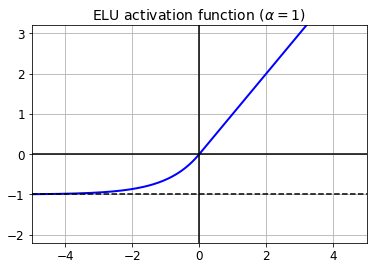

In [35]:

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2]);

In [36]:

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [37]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

# Batch Normalization

In [38]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


In [39]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)


In [40]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [41]:

n_epochs = 20
batch_size = 200

In [42]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

        save_path = saver.save(sess, "./tf_logs/my_model_final.ckpt")

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742


In [43]:

[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [46]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

# Gradient Clipping

In [60]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [61]:
learning_rate = 0.01

In [62]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [63]:

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [64]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [65]:
n_epochs = 20
batch_size = 200

In [66]:

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./model_zoo/my_model_final.ckpt")

0 Validation accuracy: 0.2874
1 Validation accuracy: 0.7938
2 Validation accuracy: 0.8796
3 Validation accuracy: 0.906
4 Validation accuracy: 0.9162
5 Validation accuracy: 0.9226
6 Validation accuracy: 0.9294
7 Validation accuracy: 0.935
8 Validation accuracy: 0.9376
9 Validation accuracy: 0.9418
10 Validation accuracy: 0.9456
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.954
14 Validation accuracy: 0.9562
15 Validation accuracy: 0.9564
16 Validation accuracy: 0.9584
17 Validation accuracy: 0.9594
18 Validation accuracy: 0.9622
19 Validation accuracy: 0.9614


# Reusing pretrained Layers

## Reusing a TensorFlow Model

In [54]:
reset_graph()

In [67]:
saver = tf.train.import_meta_graph("./model_zoo/my_model_final.ckpt.meta")

In [70]:

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")

root_logdir = "model_zoo"
logdir = "{}/run-{}/".format(root_logdir, now)

In [71]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [68]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [72]:
file_writer.close()